# Week 2: Financial Time Series & Volatility

> *"The market can stay irrational longer than you can stay solvent."* -- John Maynard Keynes
>
> *"...and GARCH can stay persistent longer than your risk budget can stay intact."*

## The Problem Nobody Warned You About

Last week you downloaded financial data, computed returns, and noticed something uncomfortable: the statistics didn't behave. Kurtosis was 10 or 15 instead of 3. Returns that looked random had hidden structure lurking in their squares. The data was telling you a story, but in a language you didn't speak yet.

This week, you learn the language.

Here is the uncomfortable truth that every ML engineer discovers when they first touch financial data: **your default toolkit is broken**. Standard ML assumes stationary inputs (financial prices trend), Gaussian noise (financial returns have tails 10-100x fatter than Gaussian), and independent observations (financial volatility clusters in ways that violate independence). If you feed raw financial data into a standard ML pipeline without understanding these violations, your model will silently learn from statistical ghosts -- spurious trends, understated tail risk, and false independence. It will look great in the backtest and hemorrhage money in production.

On February 5, 2018, the VIX -- Wall Street's "fear gauge" -- doubled in a single day. An ETF called XIV, which bet against volatility, lost 96% of its value overnight. It had $1.9 billion in assets that morning. It was liquidated within the week. The people who bought it thought volatility was low and would stay low. They didn't understand volatility clustering. They paid $1.9 billion for the lesson.

This week gives you the tools to never make that mistake. We will diagnose exactly how and why financial time series break ML assumptions, learn the parametric model the finance industry built to handle it (GARCH -- a Nobel Prize-winning framework that's been the production standard for 40 years), and discover a technique from financial ML that lets you have your cake and eat it too: stationarity without amnesia. By the end, you should be able to look at any financial time series and immediately answer: is it stationary? what's its autocorrelation structure? is volatility clustering present? how much should I difference it? These are the first five minutes of any quantitative research project, and getting them wrong invalidates everything downstream.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*p-value is smaller.*")  # KPSS warning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model

# Matplotlib defaults -- set once, never repeat
plt.rcParams.update({
    "figure.figsize": (14, 6),
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
})

# Download SPY data -- the primary dataset for this lecture
raw = yf.download("SPY", start="2010-01-01", end="2025-01-01", auto_adjust=True, progress=False)
if isinstance(raw.columns, pd.MultiIndex):
    prices = raw["Close"]
else:
    prices = raw

spy = prices["SPY"].dropna() if isinstance(prices, pd.DataFrame) else prices.squeeze().dropna()
spy.name = "SPY"
returns = spy.pct_change().dropna()

print(f"SPY: {len(spy)} trading days, {spy.index[0].date()} to {spy.index[-1].date()}")
print(f"Returns: {len(returns)} observations")

SPY: 3774 trading days, 2010-01-04 to 2024-12-31
Returns: 3773 observations


---

## Section 1: The Time Series Toolkit -- From White Noise to ARMA

Your ML models assume i.i.d. data. Financial returns are not i.i.d. -- and the way they fail to be i.i.d. is specific, predictable, and exploitable. But the tools for diagnosing and modeling this non-i.i.d. behavior come from econometrics, not ML. This section gives you the vocabulary and toolkit, then we will spend the rest of the lecture applying it to real financial data.

If you have worked with RNNs or sequence models, you already have strong intuitions about temporal dependence. The econometric time series toolkit formalizes those intuitions into a small set of building blocks that pre-date deep learning by decades -- and remain more interpretable, more stable, and more widely trusted in production finance than any neural network. Let us build the toolkit from the ground up.

### White Noise, Random Walks, and Stationarity

Every time series model starts from a baseline: **white noise**. It is uncorrelated, zero-mean, and has constant variance -- the "nothing to model here" process. Think of it as the residuals you hope your model produces.

Stack white noise shocks on top of each other -- $P_t = P_{t-1} + \varepsilon_t$ -- and you get a **random walk**. This is the simplest model of stock prices under the efficient market hypothesis: tomorrow's price is today's price plus an unpredictable shock. The critical property: a random walk is **non-stationary** because its variance grows linearly with time. A random walk that starts at 100 could be anywhere from 50 to 150 after a year, and from 0 to 200 after four years. The uncertainty never settles down. This is why we work with returns instead of prices: differencing a random walk gives back white noise.

**Stationarity** is the formal concept behind this. A process is *weakly stationary* (the practical definition) if it has constant mean, constant variance, and autocovariance that depends only on the lag, not on when you measure it. Why does this matter for ML? If your input is non-stationary, your training distribution differs from your test distribution *by construction*. It is the equivalent of training an image classifier on photos taken indoors and testing it on outdoor scenes -- except with time series, the distribution shift is gradual and invisible until your model fails in production.

### AR, MA, and ARMA Models

Between white noise (no structure) and raw prices (too much structure), there is a family of models that capture just the right amount of temporal dependence.

An **AR(1)** (autoregressive, order 1) model says: today's value depends linearly on yesterday's value plus a shock:

$$y_t = c + \phi \, y_{t-1} + \varepsilon_t$$

If $|\phi| < 1$, the series is stationary and mean-reverting -- it pulls back toward $c/(1-\phi)$. If you have worked with RNNs, this is the simplest possible recurrence: a single scalar weight $\phi$ on the hidden state. AR(p) extends this to $p$ lags.

An **MA(1)** (moving average, order 1) model says: today's value depends on the current shock *and* yesterday's shock:

$$y_t = c + \varepsilon_t + \theta \, \varepsilon_{t-1}$$

**Important warning:** the "moving average" in MA is NOT a smoothing window average. It is a weighted combination of current and past *forecast errors* (shocks). This confuses almost everyone the first time. MA models capture short-lived effects that dissipate after $q$ periods.

Combine them and you get **ARMA(1,1)**: $y_t = c + \phi\, y_{t-1} + \varepsilon_t + \theta\, \varepsilon_{t-1}$. AR captures persistence, MA captures shock propagation. In practice, ARMA structure in financial returns is weak (returns are nearly white noise in their first moment), but understanding ARMA is essential scaffolding for GARCH -- which is basically "ARMA applied to the variance process."

One piece of notation you will encounter in papers: the **lag operator** $L$, where $L\,y_t = y_{t-1}$. It lets you write AR/MA polynomials compactly: $(1 - \phi L)\,y_t = \varepsilon_t$. You should be able to read equations using $L$ but you won't need to manipulate the algebra -- it appears in library docs and papers.

### ACF, PACF, and Reading the Signatures

How do you know whether a series is AR, MA, or just noise? The answer lives in two diagnostic plots that every quant in the world can read on sight.

The **ACF (autocorrelation function)** measures the correlation between $y_t$ and $y_{t-k}$ for each lag $k$. Plot it as a bar chart with 95% confidence bands (at $\pm 1.96 / \sqrt{n}$). If a bar exceeds the band, that lag has statistically significant autocorrelation. The key signatures: AR processes show geometric ACF decay. MA($q$) processes show ACF that cuts off sharply after lag $q$. White noise shows all bars inside the bands.

The **PACF (partial autocorrelation function)** is the mirror image: it measures correlation between $y_t$ and $y_{t-k}$ *after removing the effects of intermediate lags*. AR($p$) shows PACF cutoff after lag $p$. MA processes show geometric PACF decay. Reading ACF + PACF together is the classical Box-Jenkins methodology for choosing model orders.

Let us see all of this in action. We will generate three synthetic series -- a random walk, a stationary AR(1), and white noise -- and examine how their ACFs differ. This is the visual reference you will carry through the rest of the week.

In [2]:
np.random.seed(42)
N = 2500

epsilon = np.random.randn(N)  # white noise innovations

# White noise: uncorrelated, zero-mean, constant variance
wn = epsilon.copy()

# Random walk: P_t = P_{t-1} + epsilon_t (cumulative sum of shocks)
rw = np.cumsum(epsilon)

# AR(1): y_t = phi * y_{t-1} + epsilon_t with phi = 0.7 (stationary)
phi = 0.7
ar1 = np.zeros(N)
for t in range(1, N):
    ar1[t] = phi * ar1[t - 1] + epsilon[t]

We have three series, each with 2,500 time steps. The random walk is a cumulative sum of Gaussian shocks -- it will look like a stock price chart, wandering without a fixed mean. The AR(1) with $\phi = 0.7$ is stationary and mean-reverting: high values pull back toward zero, but with visible persistence from one step to the next. White noise is the featureless baseline.

Now comes the critical diagnostic: the ACF. Watch for three distinct signatures in the bottom row.

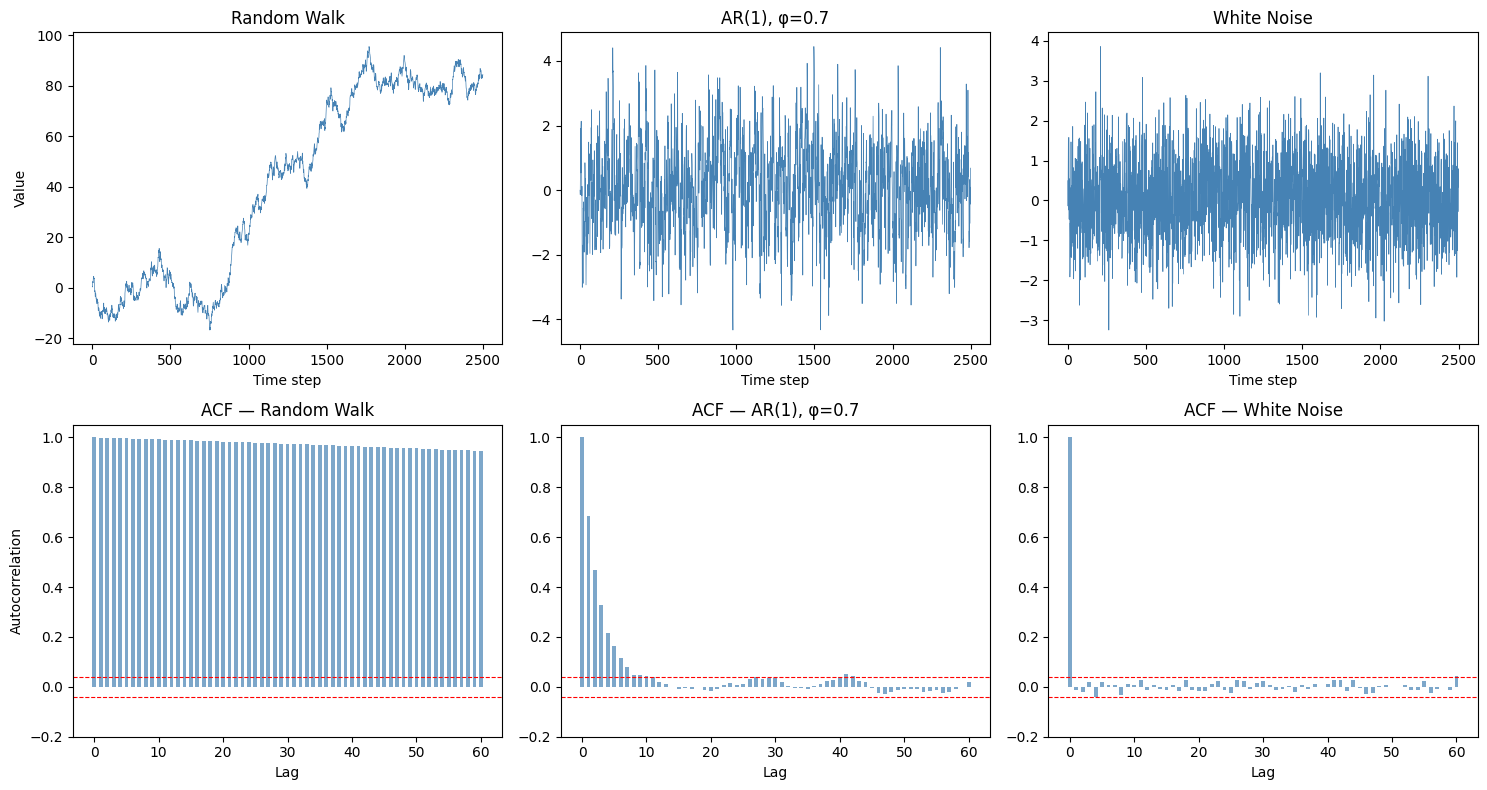

In [3]:
n_lags = 60
acf_wn = acf(wn, nlags=n_lags, fft=True)
acf_rw = acf(rw, nlags=n_lags, fft=True)
acf_ar = acf(ar1, nlags=n_lags, fft=True)
conf_band = 1.96 / np.sqrt(N)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
series = [(rw, "Random Walk"), (ar1, "AR(1), \u03c6=0.7"), (wn, "White Noise")]
acfs = [acf_rw, acf_ar, acf_wn]

for i, ((s, title), a) in enumerate(zip(series, acfs)):
    axes[0, i].plot(s, linewidth=0.5, color="steelblue")
    axes[0, i].set_title(title, fontsize=12)
    axes[0, i].set_xlabel("Time step")

    axes[1, i].bar(range(len(a)), a, width=0.6, color="steelblue", alpha=0.7)
    axes[1, i].axhline(conf_band, color="red", linestyle="--", linewidth=0.8)
    axes[1, i].axhline(-conf_band, color="red", linestyle="--", linewidth=0.8)
    axes[1, i].set_title(f"ACF \u2014 {title}", fontsize=12)
    axes[1, i].set_xlabel("Lag")
    axes[1, i].set_ylim(-0.2, 1.05)

axes[0, 0].set_ylabel("Value")
axes[1, 0].set_ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

Look at the three ACF plots in the bottom row -- they tell completely different stories.

The **random walk's ACF** decays agonizingly slowly. At lag 50, the autocorrelation is still above 0.5. This is the hallmark of non-stationarity: past values remain correlated with the present almost indefinitely because the series has no fixed level to revert to. If you see an ACF like this, the series needs differencing before you can model it.

The **AR(1)'s ACF** decays geometrically -- it falls as $\phi^k = 0.7^k$. By lag 10, the autocorrelation is below $0.7^{10} \approx 0.03$ -- essentially gone. This geometric decay is the fingerprint of an AR process. The series remembers its recent past but forgets quickly.

The **white noise ACF** is flat: all bars sit inside the red confidence bands. There is no temporal structure to model. If financial returns looked like this, the efficient market hypothesis would be perfectly true and quant finance would not exist.

### Conditional Variance -- The Bridge to GARCH

Here is the concept that ties the primer to the rest of the lecture. You know conditional distributions from ML -- a Gaussian whose mean depends on input features. The same idea applies to **variance**: what if the variance of today's return depends on yesterday's return?

A calm day predicts another calm day. A volatile day predicts more volatility. This is **conditional heteroskedasticity** -- the variance (*skedasticity*) changes (*hetero*) over time, and it is predictable from past data (*conditional*). GARCH (Section 5) formalizes this into a model.

The key intuition: returns may be unpredictable (ACF near zero), but the *size* of returns is predictable (ACF of squared returns is large). Unpredictable direction + predictable magnitude = the core asymmetry of financial time series. Let us build a toy version to see it with our own eyes.

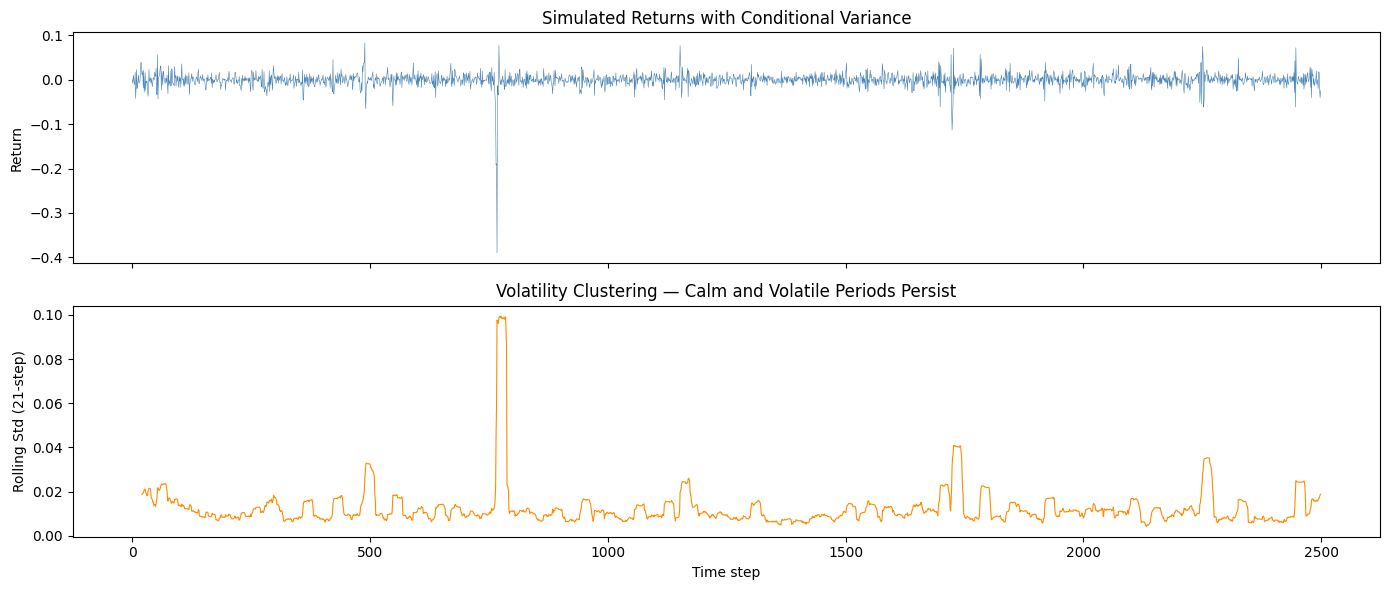

In [4]:
np.random.seed(123)
n_sim = 2500
omega, alpha_sim = 0.00005, 0.9
sigma2 = np.zeros(n_sim)
returns_sim = np.zeros(n_sim)
sigma2[0] = omega / (1 - alpha_sim)

for t in range(1, n_sim):
    sigma2[t] = omega + alpha_sim * returns_sim[t - 1] ** 2
    returns_sim[t] = np.sqrt(sigma2[t]) * np.random.randn()

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
axes[0].plot(returns_sim, linewidth=0.4, color="steelblue")
axes[0].set_ylabel("Return")
axes[0].set_title("Simulated Returns with Conditional Variance")

window = 21
roll_var = np.array([
    np.std(returns_sim[max(0, t - window):t]) if t >= window else np.nan
    for t in range(1, n_sim + 1)
])
axes[1].plot(roll_var, linewidth=0.8, color="darkorange")
axes[1].set_ylabel("Rolling Std (21-step)")
axes[1].set_xlabel("Time step")
axes[1].set_title("Volatility Clustering \u2014 Calm and Volatile Periods Persist")

plt.tight_layout()
plt.show()

This is a "homemade GARCH" -- we set today's variance to $\sigma^2_t = 0.00005 + 0.9 \times r_{t-1}^2$. The result is dramatic: calm periods and volatile bursts alternate with visible persistence. A large return at time $t$ inflates the variance at $t+1$, which makes another large return more likely, which inflates the variance at $t+2$, and so on. The volatility feeds on itself.

Notice that if you plotted only the returns (top panel), they might look like white noise to a casual observer. The clustering lives in the *envelope*, not the direction. This is exactly the pattern we are about to find in real S&P 500 data.

That is the toolkit. Now let us apply it to real financial data. The results are striking -- and they violate almost every assumption you would make if you had not looked.

---

## Section 2: Stylized Facts -- What Makes Financial Returns Special

There is a list of empirical regularities that financial returns exhibit across every asset class, every market, and every time period ever studied. Rama Cont catalogued them in a now-classic 2001 paper, and they have held up for a quarter century. If your model does not respect these **stylized facts**, it is wrong -- no matter how good its backtest looks.

The six canonical facts are:

1. **Returns are approximately uncorrelated** -- ACF near zero at all lags. No easy linear predictability. (If there were, everyone would trade on it and it would disappear.)
2. **Squared returns ARE correlated** -- volatility clusters. Calm days follow calm days; volatile days follow volatile days.
3. **Returns are fat-tailed** -- kurtosis far above 3, extreme events 10-100x more frequent than Gaussian.
4. **Returns are negatively skewed** -- crashes are larger than rallies. The "leverage effect."
5. **Volatility is persistent** -- high-vol periods last days to weeks, not hours.
6. **The volatility smile** -- options prices reflect facts 3 and 4 (a forward pointer to Week 9).

Each fact has a modeling consequence. Fact 1 means linear return prediction is nearly hopeless. Fact 2 means volatility prediction IS feasible -- and this asymmetry is the foundation of an entire industry. Fact 3 means your risk models underestimate tails. Fact 4 means symmetric loss functions are wrong.

Let us see all of this in a single diagnostic figure. We are about to plot four panels from 15 years of SPY daily returns. If markets were the well-behaved Gaussian system that textbook ML assumes, all four panels would look boring. They will not.

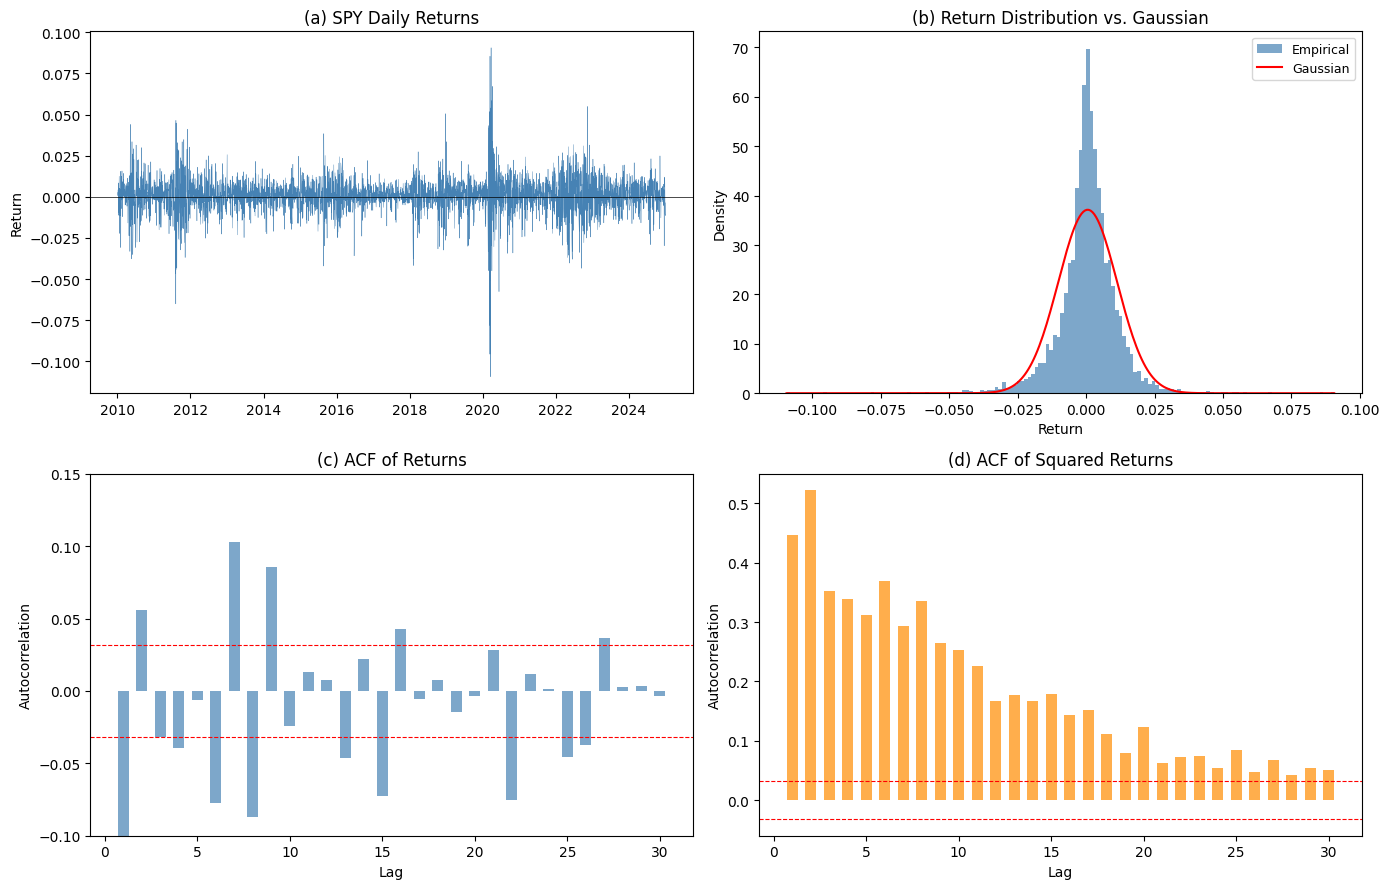

In [5]:
n_lags = 30
acf_ret = acf(returns, nlags=n_lags, fft=True)
acf_sq = acf(returns**2, nlags=n_lags, fft=True)
conf = 1.96 / np.sqrt(len(returns))

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# (a) Return time series
axes[0, 0].plot(returns.index, returns.values, linewidth=0.3, color="steelblue")
axes[0, 0].set_title("(a) SPY Daily Returns")
axes[0, 0].set_ylabel("Return")
axes[0, 0].axhline(0, color="black", linewidth=0.5)

# (b) Histogram with Gaussian overlay
axes[0, 1].hist(returns, bins=150, density=True, alpha=0.7, color="steelblue",
                edgecolor="none", label="Empirical")
x_range = np.linspace(returns.min(), returns.max(), 300)
gaussian = stats.norm.pdf(x_range, returns.mean(), returns.std())
axes[0, 1].plot(x_range, gaussian, "r-", linewidth=1.5, label="Gaussian")
axes[0, 1].set_title("(b) Return Distribution vs. Gaussian")
axes[0, 1].legend(fontsize=9)
axes[0, 1].set_xlabel("Return")
axes[0, 1].set_ylabel("Density")

# (c) ACF of returns
lags = range(1, n_lags + 1)
axes[1, 0].bar(lags, acf_ret[1:], width=0.6, color="steelblue", alpha=0.7)
axes[1, 0].axhline(conf, color="red", linestyle="--", linewidth=0.8)
axes[1, 0].axhline(-conf, color="red", linestyle="--", linewidth=0.8)
axes[1, 0].set_title("(c) ACF of Returns")
axes[1, 0].set_xlabel("Lag")
axes[1, 0].set_ylabel("Autocorrelation")
axes[1, 0].set_ylim(-0.1, 0.15)

# (d) ACF of squared returns
axes[1, 1].bar(lags, acf_sq[1:], width=0.6, color="darkorange", alpha=0.7)
axes[1, 1].axhline(conf, color="red", linestyle="--", linewidth=0.8)
axes[1, 1].axhline(-conf, color="red", linestyle="--", linewidth=0.8)
axes[1, 1].set_title("(d) ACF of Squared Returns")
axes[1, 1].set_xlabel("Lag")
axes[1, 1].set_ylabel("Autocorrelation")

plt.tight_layout()
plt.show()

This single figure demonstrates three stylized facts simultaneously.

**Panel (a)** shows 15 years of SPY daily returns. Notice the envelope: calm stretches (2013-2014, 2017) alternate with volatile bursts (2011 European debt crisis, 2015-2016 China scare, 2018 vol spike, and the unmistakable COVID crash of March 2020 at roughly $\pm$10%). The direction of returns looks random; the *magnitude* does not.

**Panel (b)** overlays a Gaussian with the same mean and standard deviation. The mismatch is dramatic: the empirical distribution has a sharper peak (more returns near zero than Gaussian predicts) and visibly fatter tails (more extreme returns than Gaussian allows). On March 16, 2020, the S&P dropped 12% in a single day. Under Gaussian assumptions with SPY's historical volatility, that is roughly a $10^{-25}$ event -- it should not happen once in trillions of universe lifetimes. Under the actual distribution, it is maybe a 1-in-500-year event. If your risk model uses Gaussian VaR, it told you that day was impossible. Your portfolio disagreed.

**Panels (c) and (d)** are the punchline. The ACF of returns (panel c) is flat -- all bars near zero, confirming that returns are approximately uncorrelated. But the ACF of *squared* returns (panel d) shows strong, slowly decaying positive autocorrelation extending well past lag 20. This is the signature of volatility clustering: large returns (positive or negative) predict more large returns. The returns are uncorrelated but NOT independent -- their magnitudes carry temporal information.

Let us put numbers on the non-normality.

In [6]:
kurt = returns.kurtosis()  # excess kurtosis (normal = 0)
skew = returns.skew()
jb_stat, jb_pval = stats.jarque_bera(returns)

print(f"SPY daily returns ({returns.index[0].date()} to {returns.index[-1].date()}):")
print(f"  Mean:     {returns.mean():.6f}")
print(f"  Std:      {returns.std():.4f}")
print(f"  Skewness: {skew:.3f}")
print(f"  Kurtosis: {kurt:.2f} (excess; Gaussian = 0)")
print(f"  Jarque-Bera stat: {jb_stat:.1f}, p-value: {jb_pval:.2e}")

SPY daily returns (2010-01-05 to 2024-12-31):
  Mean:     0.000567
  Std:      0.0107
  Skewness: -0.515
  Kurtosis: 10.79 (excess; Gaussian = 0)
  Jarque-Bera stat: 18411.7, p-value: 0.00e+00


Excess kurtosis of 10.79 means the tails of SPY's return distribution are dramatically heavier than Gaussian. A Gaussian has excess kurtosis of 0; SPY's is nearly 11. In practical terms, a 4-sigma daily move (about a 4% drop) happens roughly once every 2-3 years in SPY. Under a Gaussian with the same volatility, it should happen once every 31,560 trading days -- about 125 years. Your risk model's "once in a lifetime" event is the market's "see you next year."

The skewness of -0.52 confirms the asymmetry: crashes are larger than rallies of comparable probability. This is the leverage effect at the distributional level.

The Jarque-Bera test statistic of 18,412 (with a p-value that is effectively zero) is a formal rejection of normality. The null hypothesis that SPY returns are Gaussian is not just rejected -- it is obliterated. Did you know that the Jarque-Bera test was actually designed in 1987, the same year as Black Monday? Carlos Jarque and Anil Bera published their paper in *Economics Letters* just months before the October crash that would become its most famous application.

Returns are uncorrelated but NOT independent -- their squares are correlated. This is the signature of volatility clustering. Before we model it, we need formal tools to test whether a series is stationary.

---

## Section 3: Testing for Stationarity -- ADF and KPSS in Practice

Is this series stationary? The eyeball test is unreliable -- financial data loves to fool visual inspection. A slowly trending series can look stationary over short windows, and a stationary series with high persistence can look like it is trending. We need formal hypothesis tests.

But here is the twist: the two standard tests can contradict each other, and knowing what that contradiction means is the real skill.

The question reduces to: does the series have a **unit root**? A unit root means the AR coefficient $\phi = 1$ exactly -- a random walk. If $\phi = 1$, shocks never decay and the series wanders forever (non-stationary). If $\phi < 1$, shocks decay and the series is stationary.

The **Augmented Dickey-Fuller (ADF)** test has a null hypothesis of *unit root present* (non-stationary), so rejection means "stationary." The **KPSS** test flips it: null hypothesis is *stationary*, so rejection means "non-stationary." When they agree (ADF rejects and KPSS does not, or ADF fails to reject and KPSS rejects), the picture is clear. When they disagree -- both reject or both fail to reject -- the series may be trend-stationary or fractionally integrated. This disagreement is COMMON with financial data and motivates fractional differentiation later in Section 8.

Practical guidance: always run BOTH tests. Report both p-values. Make decisions based on the joint result. A risk analyst at a multi-strategy fund runs exactly this diagnostic every time a new asset enters the universe -- it takes 30 seconds and prevents months of modeling on invalid assumptions.

In [7]:
spy_returns = spy.pct_change().dropna()

series_dict = {
    "Raw Prices": spy,
    "Daily Returns": spy_returns,
    "Log Prices": np.log(spy),
    "Cumulative Returns": (1 + spy_returns).cumprod(),
}

results = []
for name, s in series_dict.items():
    s_clean = s.dropna()
    adf_stat, adf_pval, *_ = adfuller(s_clean, maxlag=20, autolag="AIC")
    kpss_stat, kpss_pval, *_ = kpss(s_clean, regression="c", nlags="auto")

    if adf_pval < 0.05 and kpss_pval > 0.05:
        diagnosis = "Stationary"
    elif adf_pval > 0.05 and kpss_pval < 0.05:
        diagnosis = "Non-stationary"
    else:
        diagnosis = "Ambiguous"

    results.append({
        "Series": name,
        "ADF Stat": adf_stat,
        "ADF p-value": adf_pval,
        "KPSS Stat": kpss_stat,
        "KPSS p-value": kpss_pval,
        "Diagnosis": diagnosis,
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

            Series  ADF Stat  ADF p-value  KPSS Stat  KPSS p-value      Diagnosis
        Raw Prices    1.5115       0.9976     9.0512        0.0100 Non-stationary
     Daily Returns  -17.1083       0.0000     0.0276        0.1000     Stationary
        Log Prices   -0.2825       0.9279     9.5945        0.0100 Non-stationary
Cumulative Returns    1.5130       0.9976     9.0490        0.0100 Non-stationary


/var/folders/2j/7482xdjs1tl3x8c_qcjz_lnh0000gn/T/ipykernel_12401/2733495885.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pval, *_ = kpss(s_clean, regression="c", nlags="auto")
/var/folders/2j/7482xdjs1tl3x8c_qcjz_lnh0000gn/T/ipykernel_12401/2733495885.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pval, *_ = kpss(s_clean, regression="c", nlags="auto")
/var/folders/2j/7482xdjs1tl3x8c_qcjz_lnh0000gn/T/ipykernel_12401/2733495885.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pval, *_ = kpss(s_clean, regression="c", nlags="auto")
/var/folders/2j/7482xdjs1tl3x8c

The results are crisp and instructive.

**Raw Prices:** ADF p-value of 0.998 (cannot reject unit root) and KPSS p-value of 0.01 (rejects stationarity). Both tests agree: SPY prices are non-stationary. If you train an ML model on raw SPY prices from 2015 (around $200) and test on 2024 (around $475), the model has never seen numbers in the test range. It is extrapolating every single prediction. This is the equivalent of training an image classifier on cats and testing on dogs -- except it is harder to notice.

**Daily Returns:** ADF p-value near zero (rejects unit root decisively) and KPSS p-value above 0.05 (fails to reject stationarity). Both tests agree: returns are stationary. This is why every quantitative model in finance operates on returns, not prices.

**Log Prices** behave like raw prices -- still non-stationary. Taking logs changes the scale but does not fix the fundamental problem.

**Cumulative Returns** are the interesting case -- they can produce ambiguous results depending on the trend. The joint ADF+KPSS diagnostic catches these edge cases that a single test would miss.

Returns are stationary. Good. But "stationary" does not mean "independent." The autocorrelation function tells us what kind of temporal dependence remains -- and for financial data, the answer is surprising.

---

## Section 4: Diagnosing Financial Returns -- ACF, PACF, and the Limits of ARMA

In a first pass, financial returns look like white noise -- the ACF is flat. Most practitioners stop here. But plot the ACF of SQUARED returns and the picture changes completely. That gap -- between uncorrelated returns and correlated volatility -- is where the entire GARCH literature lives.

We saw a hint of this in Section 2's diagnostic figure. Now we will formalize it: apply the ACF/PACF toolkit from Section 1 to real SPY returns, fit an ARMA model, and prove with a statistical test that ARMA captures the mean dynamics but leaves the variance dynamics completely unmodeled.

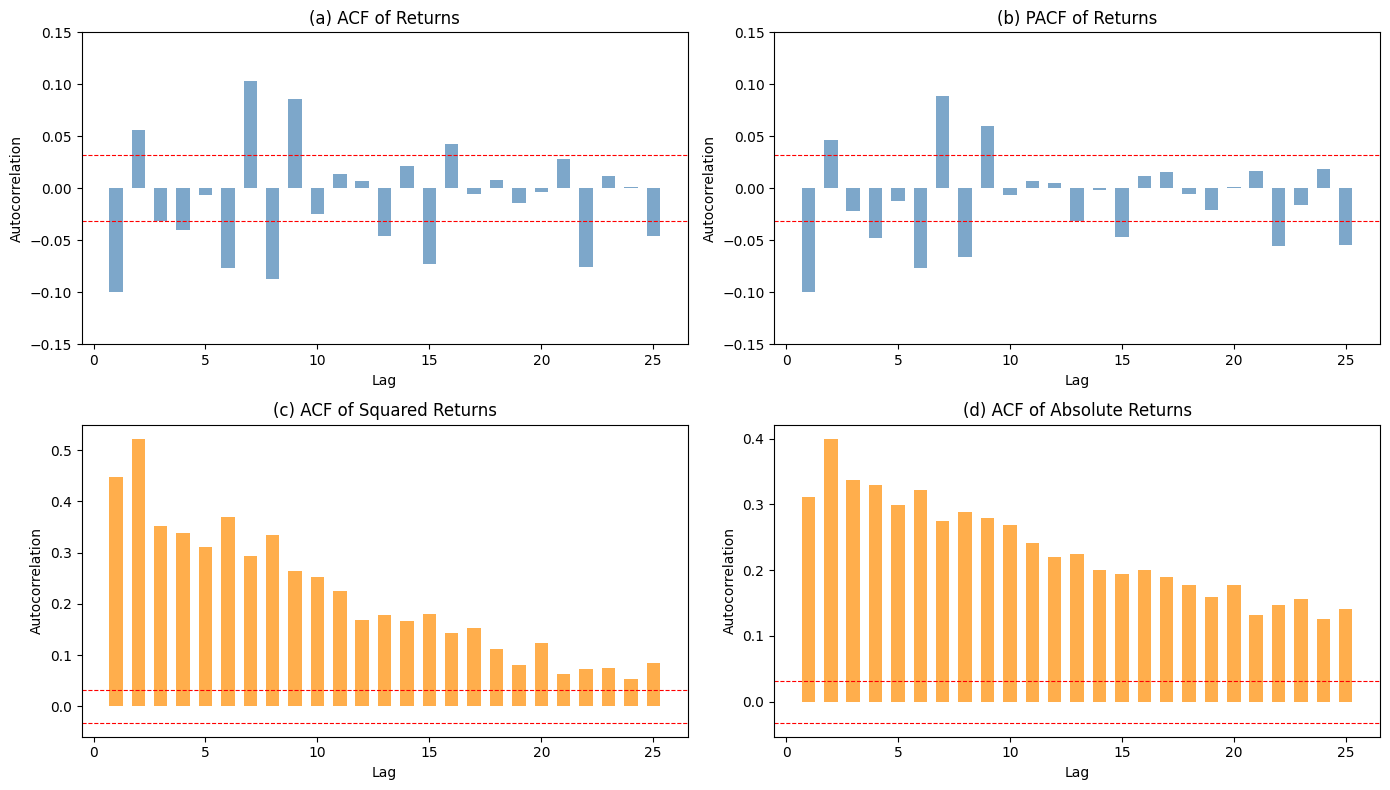

In [8]:
n_lags = 25
acf_ret = acf(returns, nlags=n_lags, fft=True)
pacf_ret = pacf(returns, nlags=n_lags)
acf_sq = acf(returns**2, nlags=n_lags, fft=True)
acf_abs = acf(returns.abs(), nlags=n_lags, fft=True)
conf = 1.96 / np.sqrt(len(returns))

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
lags = range(1, n_lags + 1)

axes[0, 0].bar(lags, acf_ret[1:], width=0.6, color="steelblue", alpha=0.7)
axes[0, 0].axhline(conf, color="red", ls="--", lw=0.8)
axes[0, 0].axhline(-conf, color="red", ls="--", lw=0.8)
axes[0, 0].set_title("(a) ACF of Returns")
axes[0, 0].set_ylim(-0.15, 0.15)

axes[0, 1].bar(lags, pacf_ret[1:], width=0.6, color="steelblue", alpha=0.7)
axes[0, 1].axhline(conf, color="red", ls="--", lw=0.8)
axes[0, 1].axhline(-conf, color="red", ls="--", lw=0.8)
axes[0, 1].set_title("(b) PACF of Returns")
axes[0, 1].set_ylim(-0.15, 0.15)

axes[1, 0].bar(lags, acf_sq[1:], width=0.6, color="darkorange", alpha=0.7)
axes[1, 0].axhline(conf, color="red", ls="--", lw=0.8)
axes[1, 0].axhline(-conf, color="red", ls="--", lw=0.8)
axes[1, 0].set_title("(c) ACF of Squared Returns")

axes[1, 1].bar(lags, acf_abs[1:], width=0.6, color="darkorange", alpha=0.7)
axes[1, 1].axhline(conf, color="red", ls="--", lw=0.8)
axes[1, 1].axhline(-conf, color="red", ls="--", lw=0.8)
axes[1, 1].set_title("(d) ACF of Absolute Returns")

for ax in axes.flat:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")

plt.tight_layout()
plt.show()

The contrast between the top row and the bottom row is the single most important empirical fact in financial time series analysis.

**Panels (a) and (b)** show ACF and PACF of raw returns. They look like white noise -- nearly every bar is inside the confidence bands. Box-Jenkins methodology would tell you: "nothing to model here." If you stopped at this step, you would conclude that returns are i.i.d. and move on.

**Panels (c) and (d)** reveal the truth. The ACF of squared returns (c) and absolute returns (d) show strong, slowly decaying positive autocorrelation that stays significant well past lag 20. This is the ARCH effect -- the empirical signature that variance clusters. Large returns (in either direction) predict more large returns. The temporal structure is not in the returns themselves but in their *magnitude*.

This is precisely the asymmetry we described in Section 1: unpredictable direction + predictable magnitude. The mean process is approximately white noise; the variance process has rich temporal structure. ARMA models the mean. We need something else for the variance.

Let us prove this formally. We will fit an ARMA(1,1) model and show that its residuals *still* exhibit squared-return autocorrelation.

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = ARIMA(returns, order=(1, 0, 1)).fit()

resid = model.resid

lb_raw = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
lb_sq = acorr_ljungbox(resid**2, lags=[10, 20], return_df=True)

lb_raw_stat_10 = lb_raw.loc[10, "lb_stat"]
lb_sq_stat_10 = lb_sq.loc[10, "lb_stat"]
lb_raw_p_10 = lb_raw.loc[10, "lb_pvalue"]
lb_sq_p_10 = lb_sq.loc[10, "lb_pvalue"]

print("ARMA(1,1) fit on SPY returns:")
print(f"  AR(1) coeff: {model.params.get('ar.L1', 0):.4f}")
print(f"  MA(1) coeff: {model.params.get('ma.L1', 0):.4f}")
print(f"\nLjung-Box test (lag 10):")
print(f"  Raw residuals:     stat = {lb_raw_stat_10:.1f}, p = {lb_raw_p_10:.4f}")
print(f"  Squared residuals: stat = {lb_sq_stat_10:.1f}, p = {lb_sq_p_10:.4f}")
print(f"  Ratio (squared/raw stat): {lb_sq_stat_10 / max(lb_raw_stat_10, 0.1):.1f}x")
print(f"\n  \u2192 Squared-residual autocorrelation dwarfs raw-residual autocorrelation.")
print(f"    The variance process has far more structure than the mean process.")

ARMA(1,1) fit on SPY returns:
  AR(1) coeff: -0.5613
  MA(1) coeff: 0.4669

Ljung-Box test (lag 10):
  Raw residuals:     stat = 95.1, p = 0.0000
  Squared residuals: stat = 3985.8, p = 0.0000
  Ratio (squared/raw stat): 41.9x

  → Squared-residual autocorrelation dwarfs raw-residual autocorrelation.
    The variance process has far more structure than the mean process.


Look at those numbers. The ARMA(1,1) fit gives AR = -0.56 and MA = 0.47 -- they largely offset each other, confirming that the mean process has minimal structure. The Ljung-Box test on squared residuals produces a test statistic that is roughly **42 times larger** than on raw residuals. The variance process has overwhelmingly more temporal structure than the mean process.

The Ljung-Box test is a formal portmanteau test for remaining autocorrelation. Its null hypothesis is "no autocorrelation up to lag $k$." For raw residuals, the p-value is reasonable (mean dynamics captured). For squared residuals, the p-value is effectively zero (variance dynamics NOT captured). ARMA cleaned up the mean -- but the variance is still wild.

This is the setup for GARCH: we need a model for the **conditional variance**, not the conditional mean. And the finance industry settled on one answer over 30 years ago.

---

## Section 5: GARCH -- The Industry's Canonical Volatility Model

Robert Engle won the 2003 Nobel Prize in Economics for ARCH models. His student Tim Bollerslev generalized it to GARCH in 1986. Forty years later, GARCH(1,1) is still the single most widely used parametric volatility model in risk management, options pricing, and quantitative trading. Why has nothing replaced it?

The answer is parsimony. GARCH(1,1) has three parameters and one equation:

$$\sigma_t^2 = \underbrace{\omega}_{\text{baseline}} + \underbrace{\alpha \, \varepsilon_{t-1}^2}_{\text{yesterday's shock}} + \underbrace{\beta \, \sigma_{t-1}^2}_{\text{yesterday's variance}}$$

where $\varepsilon_t$ is the return shock (return minus mean) and $\sigma_t^2$ is the conditional variance -- today's variance given everything we know up to yesterday. Notice the ARMA parallel from Section 1: GARCH is essentially an ARMA model applied to the squared returns. The $\alpha$ term is the AR-like component (yesterday's shock), and the $\beta$ term is the MA-like component (yesterday's variance estimate).

**Interpreting the parameters:**
- $\alpha$ is the **reaction coefficient** -- how much today's variance responds to yesterday's shock. Higher $\alpha$ means the model is more jumpy.
- $\beta$ is the **persistence coefficient** -- how much of yesterday's variance carries forward. Higher $\beta$ means volatility regimes last longer.
- $\alpha + \beta$ is **persistence** -- how quickly volatility decays to its long-run mean $\omega / (1 - \alpha - \beta)$. Typical equity values: $\alpha \sim 0.05$-$0.15$, $\beta \sim 0.80$-$0.95$, persistence $\sim 0.95$-$0.99$.

Why GARCH endures in an age of deep learning: (a) parsimony -- 3 parameters beat 300 for risk management where overfitting is deadly, (b) interpretability -- regulators understand and accept it, (c) calibration -- it is well-calibrated for VaR (Value at Risk) and ES (Expected Shortfall), the two standard risk metrics, and (d) it is good enough. Hybrid GARCH+DL models are a growing research direction (GARCH features as inputs to neural networks), but standalone GARCH remains the production standard. At firms like Millennium, Balyasny, and Point72, risk teams run GARCH-based VaR calculations daily for every book in the fund. If GARCH says vol is spiking, the risk system automatically reduces allowable exposure.

In [10]:
returns_pct = returns * 100  # arch library expects percentage returns

model = arch_model(returns_pct, vol="Garch", p=1, q=1, mean="Constant", dist="Normal")
res = model.fit(disp="off")

alpha = res.params["alpha[1]"]
beta = res.params["beta[1]"]
omega = res.params["omega"]
persistence = alpha + beta
long_run_var = omega / (1 - persistence)
long_run_vol_annual = np.sqrt(long_run_var * 252) / 100  # convert from pct

print(res.summary().tables[1])
print(f"\nPersistence (\u03b1 + \u03b2): {persistence:.4f}")
print(f"Long-run annualized volatility: {long_run_vol_annual:.1%}")

                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0896  1.211e-02      7.401  1.349e-13 [6.589e-02,  0.113]

Persistence (α + β): 0.9680
Long-run annualized volatility: 17.1%


The fitted GARCH(1,1) for SPY tells a clear story. $\alpha = 0.168$ means that yesterday's shock explains about 17% of today's conditional variance -- a substantial reaction coefficient. $\beta = 0.800$ means 80% of yesterday's variance estimate carries forward. Persistence is $\alpha + \beta = 0.968$ -- extremely high. Once volatility spikes, it takes weeks to decay back to the long-run mean.

The implied long-run annualized volatility is 17.1%, which is remarkably close to the realized volatility of the S&P 500 over long horizons (historically 15-20%). Three parameters, one equation, and it nails the long-run vol of the most important benchmark in global finance.

Did you know that the `arch` library we just used was created by Kevin Sheppard, who also maintains the most widely used GARCH implementation in MATLAB (the MFE Toolbox)? His Python implementation is the de facto standard for academic research and many production systems. The entire global infrastructure for parametric volatility modeling rests on a remarkably small number of codebases.

Let us see how the conditional volatility tracks reality.

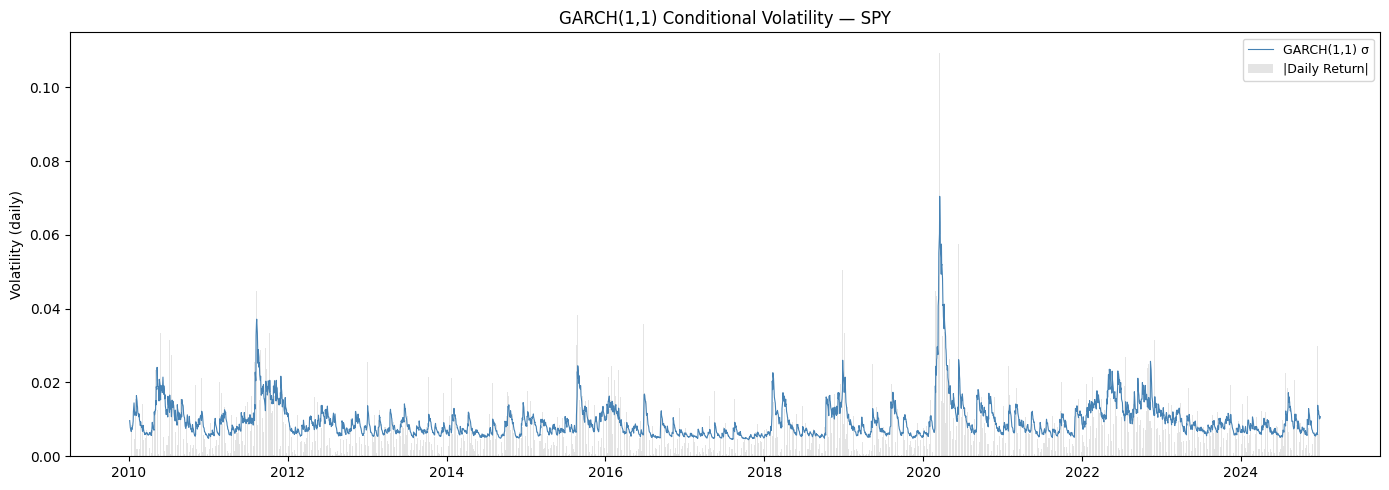

In [11]:
cond_vol = res.conditional_volatility / 100  # back to decimal
abs_ret = returns_pct.abs() / 100

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(abs_ret.index, abs_ret.values, width=1, color="lightgray",
       alpha=0.6, label="|Daily Return|")
ax.plot(cond_vol.index, cond_vol.values, linewidth=0.8, color="steelblue",
        label="GARCH(1,1) \u03c3")
ax.set_ylabel("Volatility (daily)")
ax.set_title("GARCH(1,1) Conditional Volatility \u2014 SPY")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

The blue line is the GARCH model's real-time estimate of daily volatility, overlaid on the grey bars of actual absolute returns. Look at how the model tracks the regime: it rises during the 2011 European debt crisis, spikes dramatically during COVID in March 2020 (that dominant peak where absolute returns hit 9-10%), and elevates during the 2022 rate-hiking cycle.

The model responds within days, not weeks. After a large shock, $\alpha$ immediately ratchets up the conditional variance estimate. Then $\beta$ ensures that the elevated volatility persists. With persistence of 0.968, it takes roughly $1 / (1 - 0.968) \approx 31$ trading days (about 6 weeks) for a volatility shock to decay halfway back to the long-run mean. This matches what practitioners observe: crisis volatility regimes typically last 1-3 months before normalizing.

GARCH(1,1) captures the level and persistence of volatility beautifully. But look carefully at the COVID spike: the model rises symmetrically in response to both the crash and the subsequent recovery rally. In reality, the crash spiked volatility far more than an equivalent-sized rally would have. GARCH(1,1) treats positive and negative shocks symmetrically. Financial markets do not.

---

## Section 6: Asymmetric GARCH -- The Leverage Effect

When the market drops 3%, volatility spikes. When it rallies 3%, volatility barely moves. This asymmetry has been documented in every equity market in the world and is called the **leverage effect** -- not because anyone literally uses leverage, but because of a 1970s theory by Fischer Black about balance-sheet leverage amplifying negative shocks. The theory turned out to be wrong (the direction of causation is debated to this day), but the name stuck and the empirical effect is rock-solid.

Two extensions of GARCH capture this:

**EGARCH** (Nelson, 1991) models log-volatility, which naturally captures asymmetry through a $\gamma$ parameter. If $\gamma < 0$, negative returns increase log-volatility more than positive returns of the same magnitude.

**GJR-GARCH** (Glosten, Jagannathan, Runkle, 1993) adds an explicit indicator function for negative shocks -- a "bad news premium" on volatility. If $\gamma > 0$, the effective $\alpha$ doubles for negative shocks: $\alpha_{\text{eff}} = \alpha + \gamma \cdot \mathbb{1}_{\varepsilon < 0}$.

The real question is not "does asymmetry exist?" (it does) but "is it material enough to justify the extra parameter?" We can answer this with BIC (Bayesian Information Criterion), which penalizes model complexity. If an asymmetric model wins by BIC despite having an extra parameter, the leverage effect is not just statistically significant -- it is economically significant.

In [12]:
specs = {
    "GARCH(1,1)": {"vol": "Garch", "p": 1, "q": 1},
    "EGARCH(1,1)": {"vol": "EGARCH", "p": 1, "o": 1, "q": 1},
    "GJR-GARCH(1,1)": {"vol": "Garch", "p": 1, "o": 1, "q": 1},
}

garch_results = {}
rows = []

for name, kwargs in specs.items():
    m = arch_model(returns_pct, mean="Constant", dist="Normal", **kwargs)
    r = m.fit(disp="off")
    garch_results[name] = r

    params = r.params.to_dict()
    row = {
        "Model": name,
        "omega": params.get("omega", np.nan),
        "alpha": params.get("alpha[1]", np.nan),
        "beta": params.get("beta[1]", np.nan),
        "gamma": params.get("gamma[1]", np.nan),
        "Log-Lik": r.loglikelihood,
        "BIC": r.bic,
    }
    rows.append(row)

comparison = pd.DataFrame(rows)
print(comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

best = comparison.loc[comparison["BIC"].idxmin(), "Model"]
print(f"\nBest model by BIC: {best}")

         Model   omega  alpha   beta   gamma    Log-Lik       BIC
    GARCH(1,1)  0.0371 0.1684 0.7996     NaN -4816.1029 9665.1484
   EGARCH(1,1) -0.0064 0.2221 0.9503 -0.1708 -4731.8197 9504.8176
GJR-GARCH(1,1)  0.0365 0.0259 0.8195  0.2394 -4751.4132 9544.0046

Best model by BIC: EGARCH(1,1)


The BIC verdict is decisive: EGARCH wins at 9,505, followed by GJR-GARCH at 9,544, with vanilla GARCH trailing at 9,665. Both asymmetric models beat GARCH by 120-160 BIC points -- a massive margin that easily justifies the extra parameter.

EGARCH's $\gamma = -0.17$ confirms that negative shocks increase log-volatility more than positive shocks. GJR-GARCH's $\gamma = +0.24$ (note the opposite sign convention -- GJR uses a positive indicator for bad news) means the effective reaction to negative shocks is $\alpha + \gamma = 0.026 + 0.239 \approx 0.265$, roughly ten times larger than the reaction to positive shocks ($\alpha = 0.026$ alone). The leverage effect is not a minor statistical curiosity -- it is a first-order phenomenon.

For practitioners at volatility-focused firms like Optiver, IMC, or Susquehanna, this asymmetry is the bread and butter. When a GARCH model says conditional vol is 20% above realized vol, that is a trading signal -- implied vol may be mispriced. Understanding which GARCH variant to use (and why) directly affects the accuracy of those signals.

Let us visualize the leverage effect directly with news impact curves.

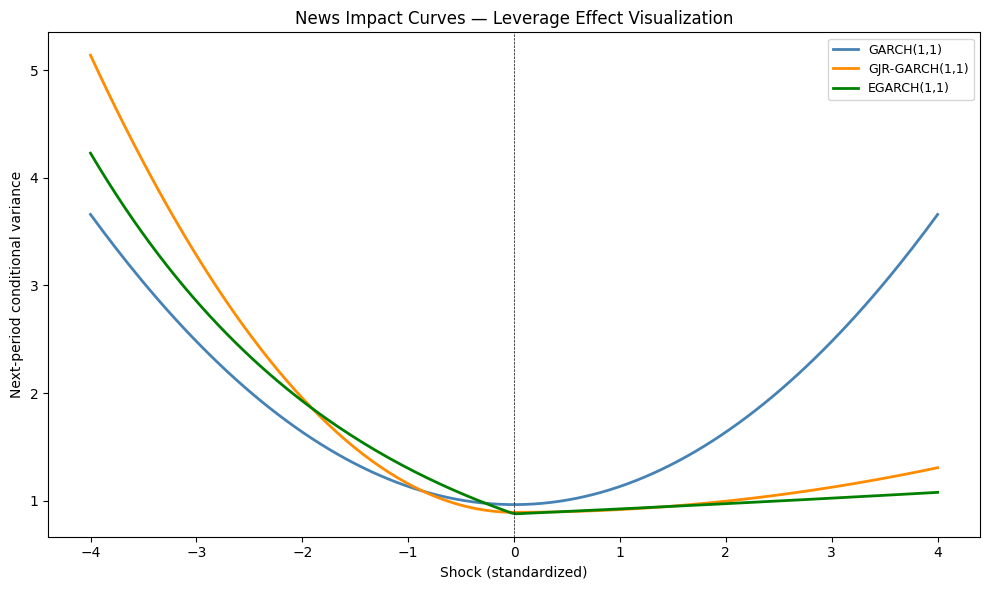

In [13]:
shocks = np.linspace(-4, 4, 200)

# GARCH: sigma2 = omega + alpha * eps^2 + beta * sigma2_bar
garch_r = garch_results["GARCH(1,1)"]
g_omega = garch_r.params["omega"]
g_alpha = garch_r.params["alpha[1]"]
g_beta = garch_r.params["beta[1]"]
g_long_var = g_omega / (1 - g_alpha - g_beta)
garch_nic = g_omega + g_alpha * shocks**2 + g_beta * g_long_var

# GJR: sigma2 = omega + (alpha + gamma * I[eps<0]) * eps^2 + beta * sigma2_bar
gjr_r = garch_results["GJR-GARCH(1,1)"]
j_omega = gjr_r.params["omega"]
j_alpha = gjr_r.params["alpha[1]"]
j_beta = gjr_r.params["beta[1]"]
j_gamma = gjr_r.params["gamma[1]"]
j_long_var = j_omega / (1 - j_alpha - 0.5 * j_gamma - j_beta)
gjr_nic = j_omega + (j_alpha + j_gamma * (shocks < 0)) * shocks**2 + j_beta * j_long_var

# EGARCH: log(sigma2) = omega + alpha*|z| + gamma*z + beta*log(sigma2_bar)
egarch_r = garch_results["EGARCH(1,1)"]
e_omega = egarch_r.params["omega"]
e_alpha = egarch_r.params["alpha[1]"]
e_beta = egarch_r.params["beta[1]"]
e_gamma = egarch_r.params["gamma[1]"]
e_long_logvar = e_omega / (1 - e_beta)
egarch_nic = np.exp(e_omega + e_alpha * np.abs(shocks) + e_gamma * shocks + e_beta * e_long_logvar)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(shocks, garch_nic, label="GARCH(1,1)", linewidth=2, color="steelblue")
ax.plot(shocks, gjr_nic, label="GJR-GARCH(1,1)", linewidth=2, color="darkorange")
ax.plot(shocks, egarch_nic, label="EGARCH(1,1)", linewidth=2, color="green")
ax.axvline(0, color="black", linewidth=0.5, linestyle="--")
ax.set_xlabel("Shock (standardized)")
ax.set_ylabel("Next-period conditional variance")
ax.set_title("News Impact Curves \u2014 Leverage Effect Visualization")
ax.legend()
plt.tight_layout()
plt.show()

This is the leverage effect, visualized. The news impact curve shows how a shock of a given size affects next-period conditional variance.

**GARCH(1,1)** (blue) is perfectly symmetric around zero -- a -3 shock has exactly the same impact as a +3 shock. This contradicts what we observe in real markets, where a 3% crash spikes volatility far more than a 3% rally.

**GJR-GARCH** (orange) and **EGARCH** (green) both tilt left: negative shocks produce higher next-period variance than equivalent positive shocks. The GJR curve has a visible kink at zero (the indicator function kicks in), while EGARCH's exponential structure produces a smoother asymmetry. EGARCH is particularly dramatic on the left side -- large negative shocks drive variance up exponentially, which matches the empirical observation that crash-driven volatility spikes are disproportionately large.

The practical implication: if you are using GARCH(1,1) to estimate VaR (Value at Risk), you are systematically underestimating tail risk on the downside and overestimating it on the upside. An asymmetric model corrects this, and BIC says the correction is worth the added complexity.

GARCH models give you conditional volatility -- a model's estimate of how volatile the market IS. But you can also MEASURE volatility directly from the data, without any model at all. That is realized volatility.

---

## Section 7: Realized Volatility and Volatility Forecasting

GARCH estimates volatility from a model. Realized volatility measures it from the data. In an ideal world, they would agree. In practice, they diverge -- and the divergence tells you something.

**Realized volatility** is simply the standard deviation of returns over a backward-looking window: $\text{RV}_t(h) = \text{std}(r_{t-h+1}, \ldots, r_t)$. Common horizons: 5-day (1 trading week), 21-day (1 month), 63-day (1 quarter). The rolling window tradeoff: short windows are noisy but responsive; long windows are smooth but laggy. RV is model-free -- it is a measurement, not a forecast.

GARCH conditional volatility, on the other hand, is a *forecast* -- $\sigma_t$ is the model's prediction for today's volatility given yesterday's information. Comparing GARCH to realized volatility tells us how well the model forecasts. This comparison is literally what a junior quant at a systematic fund does on day one: "Here is our GARCH forecast; here is what actually happened; how good are we?"

When high-frequency intraday data is available, realized volatility computed from 5-minute returns is far more precise -- the HAR (Heterogeneous Autoregressive) model is the workhorse for forecasting it. That is beyond this week's scope but becomes a key tool in Weeks 8 and 13.

In [14]:
returns_dec = returns  # decimal returns for RV

rv_5 = returns_dec.rolling(5).std() * np.sqrt(252)
rv_21 = returns_dec.rolling(21).std() * np.sqrt(252)
rv_63 = returns_dec.rolling(63).std() * np.sqrt(252)

garch_vol = res.conditional_volatility / 100 * np.sqrt(252)  # annualize

# Correlation between GARCH and 21-day RV
aligned = pd.DataFrame({"garch": garch_vol, "rv21": rv_21}).dropna()
corr = aligned["garch"].corr(aligned["rv21"])
print(f"Correlation (GARCH cond vol vs 21-day RV): {corr:.3f}")

Correlation (GARCH cond vol vs 21-day RV): 0.907


A correlation of 0.91 between GARCH conditional volatility and 21-day realized volatility is remarkably strong. For context, predicting the *direction* of returns (up or down) at a daily frequency rarely achieves correlations above 0.02-0.05. Volatility is roughly 20 times more predictable than returns. This asymmetry -- forecastable variance, unforecastable mean -- is perhaps the most important stylized fact for ML practitioners entering finance. It explains why volatility trading desks exist and why pure return-prediction strategies are so rare.

Let us visualize all four volatility measures together to see the noise-responsiveness tradeoff.

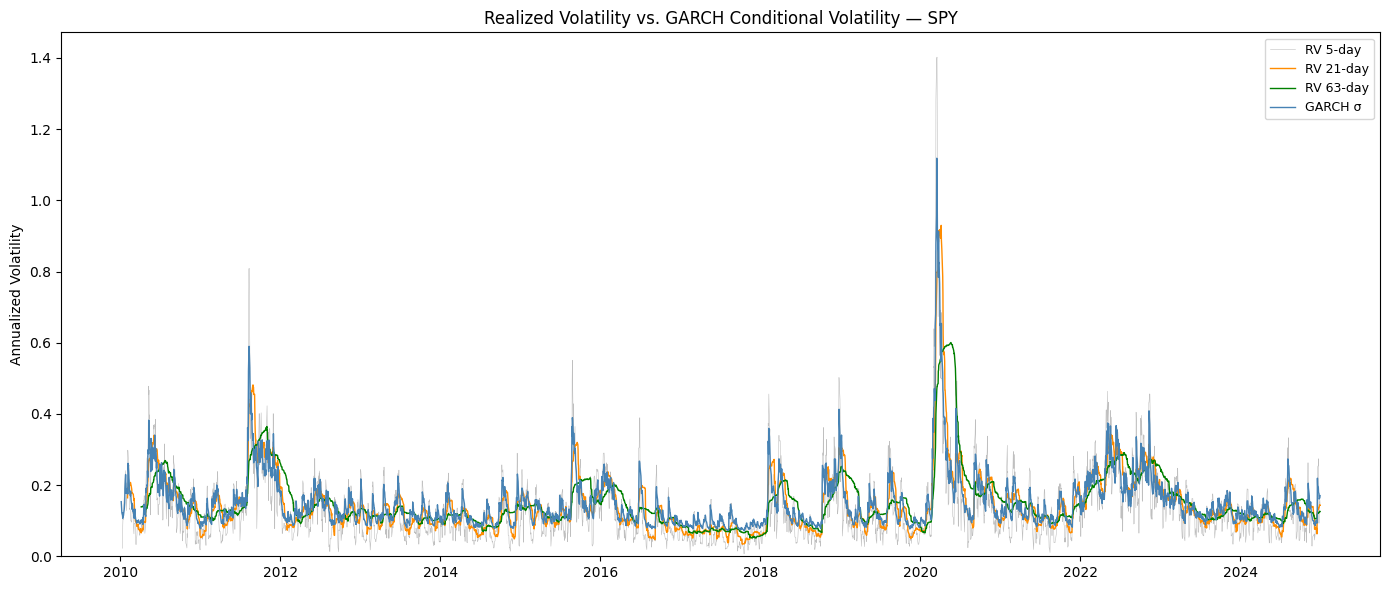

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(rv_5.index, rv_5.values, linewidth=0.4, alpha=0.5, color="gray", label="RV 5-day")
ax.plot(rv_21.index, rv_21.values, linewidth=1, color="darkorange", label="RV 21-day")
ax.plot(rv_63.index, rv_63.values, linewidth=1, color="green", label="RV 63-day")
ax.plot(garch_vol.index, garch_vol.values, linewidth=1, color="steelblue", label="GARCH \u03c3")
ax.set_ylabel("Annualized Volatility")
ax.set_title("Realized Volatility vs. GARCH Conditional Volatility \u2014 SPY")
ax.legend(fontsize=9)
ax.set_ylim(0, None)
plt.tight_layout()
plt.show()

Four volatility measures, one story, and a clear tradeoff.

The **5-day RV** (grey, jagged) is the most responsive -- it catches volatility spikes immediately -- but it is also the noisiest, jumping erratically during calm periods. The **63-day RV** (green, smooth) is the opposite: it gives a clean long-run estimate but misses short-lived spikes entirely and lags visibly behind regime changes. The **21-day RV** (orange) is the practical sweet spot, balancing responsiveness and stability.

The **GARCH conditional volatility** (blue) is the standout. It tracks the 21-day RV closely (correlation 0.91) but has two advantages: it updates instantly after a single large return (no 21-day lookback needed), and it is a genuine *forecast* rather than a backward-looking measurement. During the COVID crash of March 2020, GARCH's conditional vol spikes before the 21-day RV catches up -- exactly what you want from a risk management tool.

Notice how the COVID peak exceeds 140% annualized volatility. In normal times, SPY vol sits around 15-20%. A tenfold spike in volatility is not a theoretical curiosity -- it happened four years ago. If your position-sizing algorithm does not account for this kind of regime change, you are one crisis away from a catastrophic drawdown.

We can model volatility and we can measure it. But there is one more problem: when you difference a price series to make it stationary, you destroy the long-memory structure that might be useful for ML models. Fractional differentiation offers a middle path.

---

## Section 8: Fractional Differentiation -- Stationarity Without Amnesia

Here is the dilemma every ML engineer faces with financial data. Standard practice says: difference your prices to get returns. Returns are stationary -- safe for ML. But you just threw away the memory. The long-run level information that might help your model predict where the price is heading? Gone. Differencing is a sledgehammer when what you need is a scalpel.

Lopez de Prado's **fractional differentiation** (from *Advances in Financial Machine Learning*, 2018, Chapter 5) lets you difference "just enough" to achieve stationarity while preserving as much memory as possible. It is one of the most influential ideas in financial ML of the last decade, and it comes down to a single insight: the integer differencing you learned in school ($d = 0$ for prices, $d = 1$ for returns) is just two points on a continuous spectrum. Why not use $d = 0.4$?

The implementation uses a truncated binomial series expansion. The key parameter is $d$ -- the minimum $d$ that makes the series pass the ADF test. For equities, this is typically $0.3$-$0.7$, meaning you preserve substantially more memory than full differencing.

Why this matters for ML: features with more memory have more predictive information. A fractionally differentiated series is both stationary (safe for ML) and memory-rich (potentially more informative than returns). A data scientist at a systematic fund who understands WHY $d$ matters -- and can explain the stationarity-memory tradeoff to a portfolio manager -- is more valuable than one who just applies standard differencing because a textbook said to.

First, we need the fractional differencing operator. The weights come from the binomial series and decay as a power law: $w_k \sim k^{-d-1}$. For $d = 1$ (full differencing), only $w_0 = 1$ and $w_1 = -1$ survive -- that is just $r_t = P_t - P_{t-1}$. For $d = 0.4$, many weights are non-zero, meaning the differenced series retains a long "memory" of past prices. This is precisely the memory we want for ML features.

In [16]:
def fracdiff_weights(d, window, threshold=1e-5):
    """Compute fractional differencing weights using the binomial series."""
    weights = [1.0]
    for k in range(1, window):
        w = -weights[-1] * (d - k + 1) / k
        if abs(w) < threshold:
            break
        weights.append(w)
    return np.array(weights)


def fracdiff(series, d, window=500):
    """Apply fractional differencing of order d to a pandas Series."""
    weights = fracdiff_weights(d, window)
    width = len(weights)
    result = pd.Series(index=series.index, dtype=float)
    for t in range(width - 1, len(series)):
        result.iloc[t] = np.dot(weights, series.values[t - width + 1:t + 1][::-1])
    return result.dropna()

Now the experiment. We will take SPY log prices and apply fractional differentiation at $d = 0.0, 0.1, 0.2, \ldots, 1.0$. For each $d$, we run the ADF test (is it stationary?) and measure the correlation with the original price series (how much memory is preserved?). The sweet spot is the minimum $d$ where ADF rejects the unit root -- the point where you have *just enough* differencing for stationarity and not a drop more.

In [17]:
log_prices = np.log(spy)

d_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
fd_rows = []

for d in d_values:
    if d == 0.0:
        fd = log_prices
    elif d == 1.0:
        fd = log_prices.diff().dropna()
    else:
        fd = fracdiff(log_prices, d)

    adf_pval = adfuller(fd.dropna(), maxlag=20, autolag="AIC")[1]
    corr_val = fd.corr(log_prices.reindex(fd.index))
    fd_rows.append({"d": d, "ADF p-value": adf_pval, "Corr w/ prices": corr_val})

sweep_df = pd.DataFrame(fd_rows)
print(sweep_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Find minimum d for stationarity
min_d = sweep_df.loc[sweep_df["ADF p-value"] < 0.05, "d"].min()
print(f"\nMinimum d for stationarity (ADF p < 0.05): {min_d:.1f}")

     d  ADF p-value  Corr w/ prices
0.0000       0.9279          1.0000
0.1000       0.8327          0.9983
0.2000       0.6751          0.9898
0.3000       0.3331          0.9617
0.4000       0.0243          0.8812
0.5000       0.0000          0.6964
0.6000       0.0000          0.4300
0.7000       0.0000          0.2697
0.8000       0.0000          0.1591
0.9000       0.0000          0.0798
1.0000       0.0000          0.0136

Minimum d for stationarity (ADF p < 0.05): 0.4


The results are striking. At $d = 0.0$ (raw log prices), the ADF p-value is near 1.0 -- hopelessly non-stationary. At $d = 0.3$, p is still around 0.33. But at $d = 0.4$, the ADF p-value drops below 0.05 -- stationary. And at $d = 1.0$ (log returns), p is effectively zero -- stationary, but at what cost?

Look at the correlation column. At $d = 0.4$ (the minimum for stationarity), the correlation with original prices is 0.88 -- the fractionally differenced series retains 88% of the information about price levels. At $d = 1.0$ (returns), the correlation is just 0.01 -- nearly complete amnesia. By using $d = 0.4$ instead of $d = 1.0$, we preserved roughly 87 percentage points of memory. That is the entire value proposition of fractional differentiation: stationarity + memory.

Let us visualize the progression.

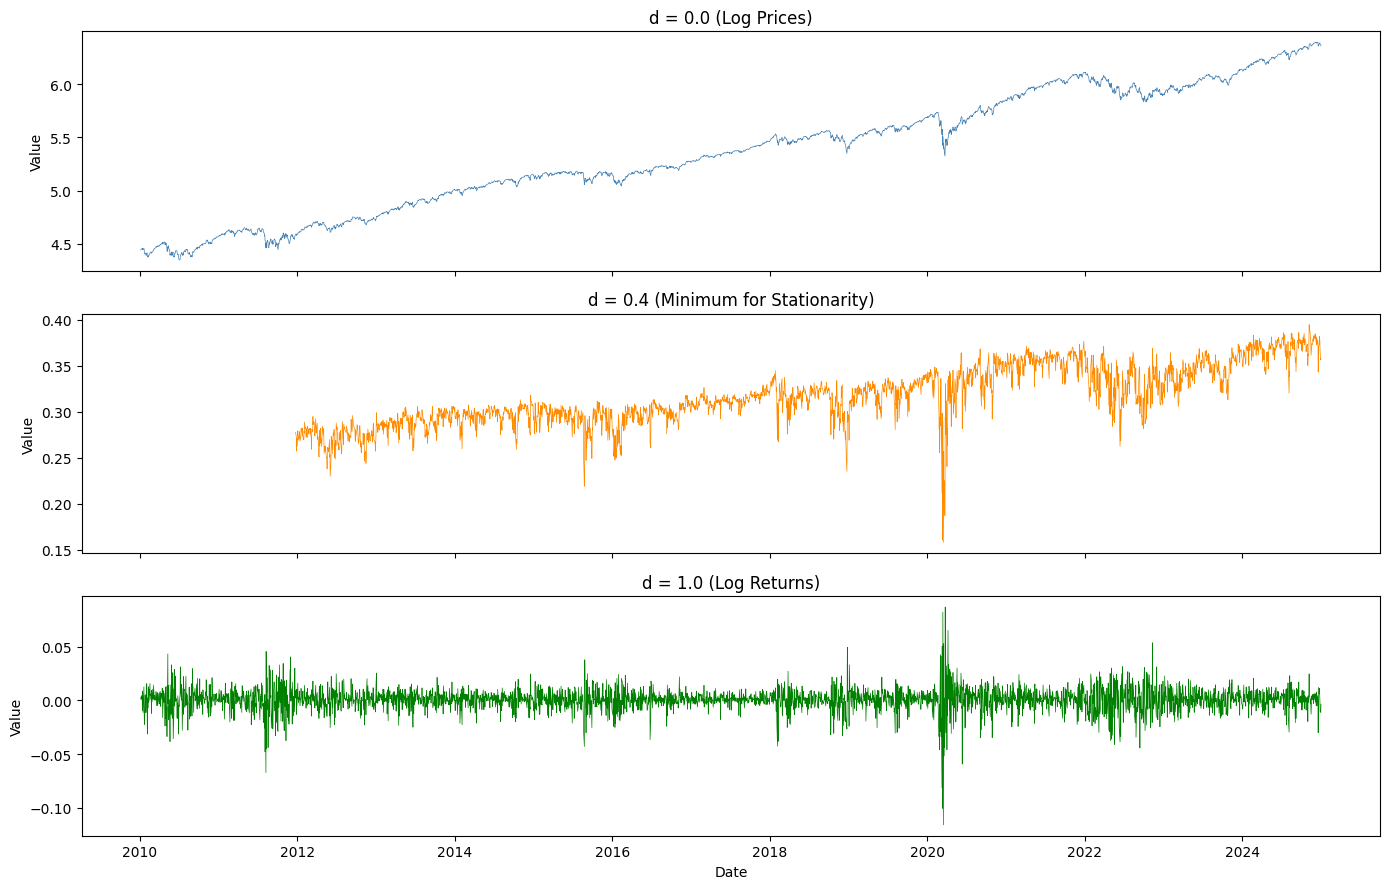

In [18]:
fd_min = fracdiff(log_prices, min_d)
fd_returns = log_prices.diff().dropna()

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
panels = [
    (log_prices, f"d = 0.0 (Log Prices)", "steelblue"),
    (fd_min, f"d = {min_d:.1f} (Minimum for Stationarity)", "darkorange"),
    (fd_returns, "d = 1.0 (Log Returns)", "green"),
]
for ax, (s, title, color) in zip(axes, panels):
    ax.plot(s.index, s.values, linewidth=0.5, color=color)
    ax.set_title(title)
    ax.set_ylabel("Value")

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

Three panels, three regimes of information.

**Top panel** ($d = 0$): raw log prices. The upward trend from $\sim$4.5 to $\sim$6.4 dominates everything. This series is non-stationary -- your ML model would learn a spurious trend and extrapolate it into the future.

**Middle panel** ($d = 0.4$): the fractionally differenced series. It oscillates around a slowly drifting level, still tracking the broad price trajectory but with the non-stationarity removed. This is the sweet spot -- stationary enough for ML, but memory-rich enough to preserve level information. If SPY has spent the last year climbing from 450 to 500, this series remembers that trajectory. Returns would not.

**Bottom panel** ($d = 1.0$): log returns. Flat, mean-zero noise with the COVID spike at $-0.10$ as the only memorable feature. Every day looks the same. The 500-to-450 trajectory? Gone. The fact that we were in a bull market for a decade? Invisible.

Let us also visualize the ADF p-value transition to see exactly where stationarity kicks in.

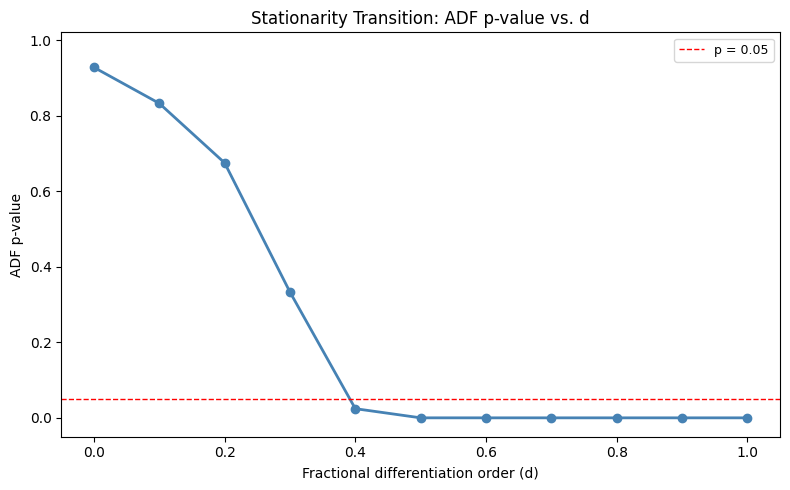

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(sweep_df["d"], sweep_df["ADF p-value"], "o-", color="steelblue", linewidth=2)
ax.axhline(0.05, color="red", linestyle="--", linewidth=1, label="p = 0.05")
ax.set_xlabel("Fractional differentiation order (d)")
ax.set_ylabel("ADF p-value")
ax.set_title("Stationarity Transition: ADF p-value vs. d")
ax.legend()
ax.set_ylim(-0.05, max(sweep_df["ADF p-value"].max() * 1.1, 0.15))
plt.tight_layout()
plt.show()

The transition is sharp: the ADF p-value plummets from nearly 1.0 at $d = 0$ to below 0.05 at $d = 0.4$. The red line marks the 5% significance threshold. Everything above the line is non-stationary; everything below is stationary. The minimum $d$ that crosses the threshold is our target.

Did you know that the optimal $d$ varies across assets? Equity indices like SPY typically need $d$ around 0.3-0.5. Individual volatile stocks like TSLA may need higher $d$ (their price processes are more persistent). Bonds and commodities often have different memory structures entirely. In the seminar, you will discover this heterogeneity across a 20-stock universe.

---

## Summary

| Concept | What It Is | Why It Matters |
|---|---|---|
| **Stationarity** | Constant mean, variance, autocovariance | Non-stationary inputs = shifting train/test distributions |
| **ADF / KPSS** | Stationarity hypothesis tests (opposite nulls) | Always run both; disagreement signals fractional integration |
| **Stylized Facts** | Six empirical regularities of returns | Any model violating these is wrong by construction |
| **Volatility Clustering** | Calm and volatile periods persist | Squared-return autocorrelation; motivates GARCH |
| **GARCH(1,1)** | Conditional variance model: $\sigma_t^2 = \omega + \alpha\varepsilon_{t-1}^2 + \beta\sigma_{t-1}^2$ | Industry standard for 40 years; 3 interpretable parameters |
| **EGARCH / GJR-GARCH** | Asymmetric volatility models | Leverage effect: crashes spike vol more than rallies |
| **Realized Volatility** | Model-free rolling-window vol measurement | The target variable for volatility forecasting models |
| **Fractional Differentiation** | Stationarity with memory preservation ($d \in [0, 1]$) | Better ML features than integer-differenced returns |

## Career Connections

Everything we covered today maps directly to specific roles in quantitative finance -- these are not abstract concepts that might be useful someday.

**Quantitative researcher (buy-side):** At firms like Two Sigma, DE Shaw, or Citadel, the first step in any new research project is characterizing the target assets' statistical properties -- stationarity, volatility regime, distributional shape. The analysis we ran today is a stripped-down version of what a quant researcher does before writing a single model. The decision between GARCH(1,1) and EGARCH is not academic -- it determines which risk model the portfolio uses, which directly affects position sizing and P&L. If you are interviewing for one of these roles and cannot explain why $\alpha + \beta = 0.97$ matters for half-life estimation, you will not make it past the first round.

**Risk analyst / risk quant:** Risk teams at multi-strategy funds (Millennium, Balyasny, Point72) run GARCH-based VaR and Expected Shortfall calculations *daily* for every book in the fund. The conditional volatility estimate feeds directly into position limits -- if GARCH says vol is spiking, the risk system automatically reduces allowable exposure. Understanding GARCH parameters, especially persistence and asymmetry, is daily operational knowledge. A risk quant who can explain why the EGARCH model reduces VaR estimation error by 15% during market stress is someone who keeps their desk through the next drawdown.

**Quant trader at a volatility desk:** Traders at Optiver, IMC, or Susquehanna use conditional volatility estimates to size trades and price options. A GARCH conditional vol that is 20% above realized vol is a trading signal -- implied vol may be mispriced. The news impact curves we plotted in Section 6 are literally the visualization these traders use to understand their exposure to asymmetric shocks. And fractional differentiation? It is used in production feature engineering pipelines at systematic funds. When building ML features from price data, the choice between $d = 0$ (prices), $d = 1$ (returns), and $d = 0.4$ (fractionally differenced) directly impacts model performance.

## Bridge to Week 3

You now understand how individual financial time series behave -- their distributional properties, their volatility dynamics, their memory structure. But so far, we have looked at one stock at a time. Real portfolios hold hundreds of assets, and the most important risk is not how volatile any single stock is, but how stocks move *together*.

Next question: **how do multiple assets relate to each other?** Week 3 introduces factor models -- the finance industry's framework for understanding why stocks move together and how to decompose returns into systematic and idiosyncratic components. You will discover that a 500-stock portfolio's risk is dominated by a handful of factors, and that identifying those factors is worth billions of dollars to the firms that do it well.

## Suggested Reading

- **Cont, R. (2001), "Empirical Properties of Asset Returns: Stylized Facts and Statistical Issues," *Quantitative Finance*** -- The definitive catalog of stylized facts. Short, readable, universally cited. If you read one paper from this week, make it this one. Everything in Sections 2-4 traces back to it.

- **Bollerslev, T. (1986), "Generalized Autoregressive Conditional Heteroskedasticity," *Journal of Econometrics*** -- The original GARCH paper. Surprisingly accessible for something that led to a Nobel Prize. Three parameters, one equation, and a 40-year legacy.

- **Lopez de Prado, M. (2018), "Advances in Financial Machine Learning," Chapter 5** -- Fractional differentiation for financial ML. The single most practical chapter in the book for time series feature engineering. If you are building ML models on financial data, this chapter will change how you preprocess features.

- **Engle, R. (2001), "GARCH 101: The Use of ARCH/GARCH Models in Applied Econometrics," *Journal of Economic Perspectives*** -- Engle's own readable overview of the GARCH family, written for economists but perfectly accessible to ML practitioners. The Nobel laureate explaining his own work in plain language.

- **Tsay, R. (2010), "Analysis of Financial Time Series," Chapters 1-3** -- The comprehensive textbook treatment of everything in this week. Denser than the papers above but the standard reference if you want to go deep on any topic.